# Evaluation of text similarity metrics using GLUE tasks

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import transformers

from bert_score import BERTScorer
from datasets import load_dataset
from datasets import concatenate_datasets
from transformers import logging
logging.set_verbosity_error()


class STSBScorer:
    def __init__(self):
        #model_name = 'gchhablani/bert-base-cased-finetuned-stsb'
        model_name = 'WillHeld/roberta-base-stsb'
        self._stsb_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        self._stsb_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
        self._stsb_model.eval()

    def score(self, sentence1, sentence2):
        stsb_tokenizer_output = self._stsb_tokenizer(sentence1, sentence2, padding=True, truncation=True, return_tensors="pt")
        stsb_model_output = self._stsb_model(**stsb_tokenizer_output)
        return stsb_model_output['logits'].item()/5

scorer = BERTScorer(lang="en", rescale_with_baseline=True)
bleu = evaluate.load("bleu")
stsb_scorer = STSBScorer()

def fetch_scores(scorer, bleu, glue_dataset_name, feature1, feature2):
    data = load_dataset('glue', glue_dataset_name)
    merged_data = concatenate_datasets([data['train'], data['validation'], data['test']])
    print(len(merged_data))
    scores = []
    count = 0
    for instance in merged_data:
        bert_score = scorer.score([instance[feature1]], [instance[feature2]], verbose=False)
        bleu_score = bleu.compute(predictions=[instance[feature1]], references=[instance[feature2]])['bleu']
        stsb_score = stsb_scorer.score(instance[feature1], instance[feature2])
        scores.append({'label': instance['label'], 'bertscore_precision': bert_score[0].item(), 'bertscore_recall': bert_score[1].item(), 'bertscore_f1': bert_score[2].item(), 'bleu': bleu_score, 'stsb_score': stsb_score})
        count += 1
        if count % 1000 == 0:
            print(count)
        if count > 100:
            break
            pass
    return scores

## MRPC

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 945.66it/s]


5801


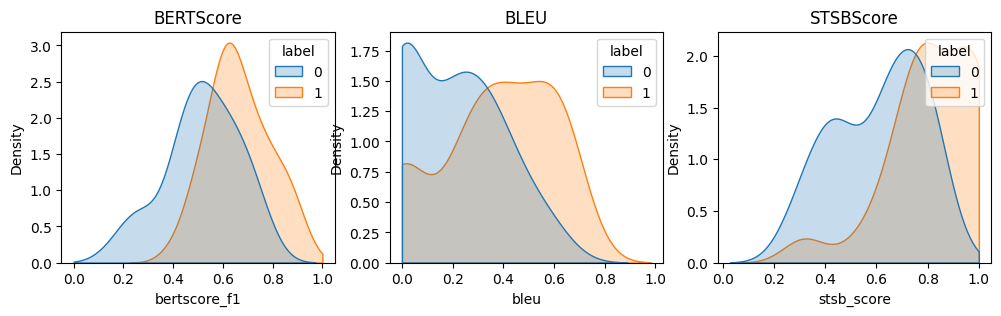

Mean


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,stsb_score
label,,,,,
0,0.523809,0.507541,0.515236,0.199138,0.605853
1,0.675920,0.651998,0.663819,0.366742,0.819206


Standard deviation


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,stsb_score
label,,,,,
0,0.172313,0.169555,0.149113,0.188290,0.173399
1,0.136383,0.141494,0.125048,0.224078,0.173985


In [5]:
scores = fetch_scores(scorer, bleu, 'mrpc', 'sentence1', 'sentence2')
scores_df = pd.DataFrame(scores)
fix, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.kdeplot(scores_df, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0])
sns.kdeplot(scores_df, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1])
sns.kdeplot(scores_df, x="stsb_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[2])
axes[0].set_title("BERTScore")
axes[1].set_title("BLEU")
axes[2].set_title("STSBScore")
plt.show()
print('Mean')
display(scores_df.groupby('label').mean())
print('Standard deviation')
display(scores_df.groupby('label').std())

## QQP

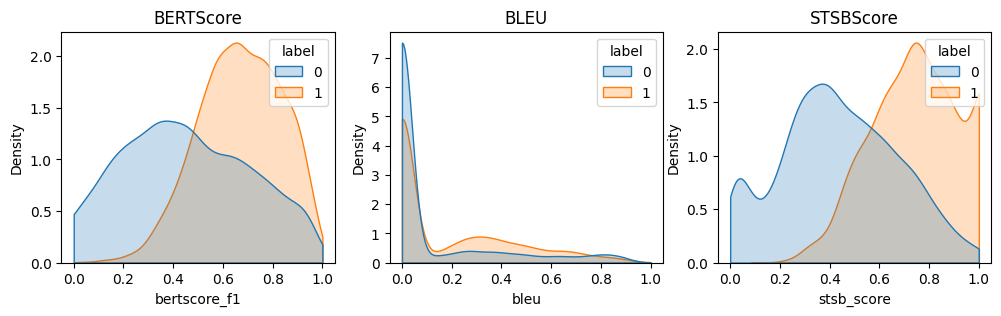

Mean


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,stsb_score
label,,,,,
0,0.436606,0.444025,0.440162,0.112826,0.437482
1,0.671411,0.667088,0.668851,0.178038,0.754390


Standard deviation


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,stsb_score
label,,,,,
0,0.275016,0.275008,0.264503,0.232348,0.235778
1,0.180207,0.181801,0.166379,0.247170,0.181519


In [ ]:
scores_qqp = fetch_scores(scorer, bleu, 'qqp', 'question1', 'question2')
scores_df = pd.DataFrame(scores_qqp)
fix, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.kdeplot(scores_df, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0])
sns.kdeplot(scores_df, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1])
sns.kdeplot(scores_df, x="stsb_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[2])
axes[0].set_title("BERTScore")
axes[1].set_title("BLEU")
axes[2].set_title("STSBScore")
plt.show()
print('Mean')
display(scores_df.groupby('label').mean())
print('Standard deviation')
display(scores_df.groupby('label').std())

<Axes: xlabel='bleu', ylabel='Density'>

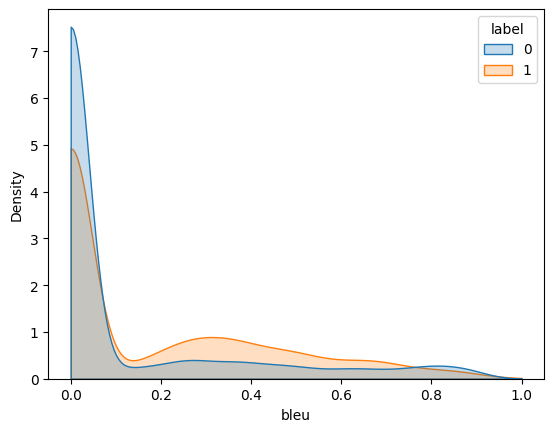

In [ ]:
scores_df = pd.DataFrame(scores_qqp)
sns.kdeplot(scores_df, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1])


## STS-B

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 744.29it/s]


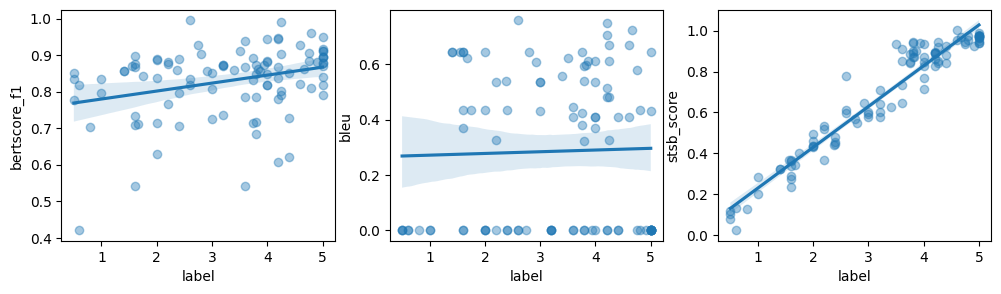

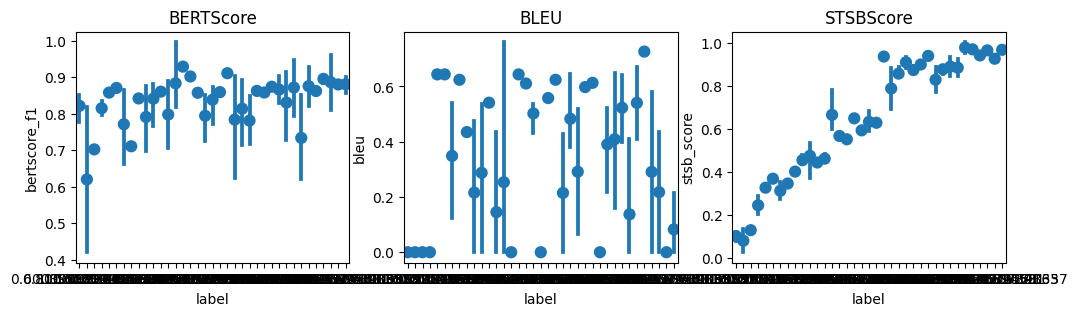

/tmp/ipykernel_6477/713963825.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(scores_df, x="bertscore_f1", hue="label", fill=True, ax=axes[0])
/tmp/ipykernel_6477/713963825.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(scores_df, x="bleu", hue="label", fill=True, ax=axes[1])
/tmp/ipykernel_6477/713963825.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(scores_df, x="stsb_score", hue="label", fill=True, ax=axes[2])


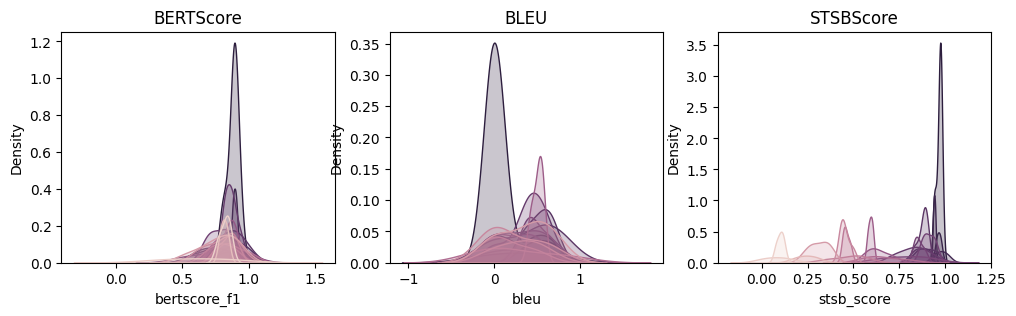

Mean


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,stsb_score
label,,,,,
0.500,0.821034,0.821047,0.821331,0.000000,0.099851
0.600,0.654696,0.584991,0.620007,0.000000,0.078094
0.800,0.637105,0.767719,0.702143,0.000000,0.127293
1.000,0.801517,0.827270,0.814637,0.000000,0.243001
1.400,0.857243,0.857253,0.857480,0.643459,0.324964
1.556,0.869999,0.870008,0.870215,0.643459,0.366913
1.600,0.758928,0.782323,0.770921,0.348422,0.310706
1.667,0.839777,0.586330,0.710676,0.624020,0.344403
1.750,0.841282,0.841293,0.841545,0.434721,0.399962


Standard deviation


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,stsb_score
label,,,,,
0.500,0.039767,0.039765,0.039701,0.000000,0.019487
0.600,0.232311,0.330905,0.281793,0.000000,0.075551
0.800,NaN,NaN,NaN,NaN,NaN
1.000,0.046095,0.009691,0.027929,0.000000,0.058247
1.400,0.000000,0.000000,0.000000,0.000000,0.000000
1.556,NaN,NaN,NaN,NaN,NaN
1.600,0.150876,0.125533,0.137334,0.291464,0.053977
1.667,NaN,NaN,NaN,NaN,NaN
1.750,NaN,NaN,NaN,NaN,NaN


In [ ]:
scores = fetch_scores(scorer, bleu, 'stsb', 'sentence1', 'sentence2')
scores_df = pd.DataFrame(scores)
fix, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.regplot(x="label", y="bertscore_f1", data=scores_df, scatter_kws={'alpha': 0.4}, ax=axes[0])
sns.regplot(x="label", y="bleu", data=scores_df, scatter_kws={'alpha': 0.4}, ax=axes[1])
sns.regplot(x="label", y="stsb_score", data=scores_df, scatter_kws={'alpha': 0.4}, ax=axes[2])
plt.show()

fix, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.pointplot(data=scores_df, x="label", y="bertscore_f1", join=False, ax=axes[0])
sns.pointplot(data=scores_df, x="label", y="bleu", join=False, ax=axes[1])
sns.pointplot(data=scores_df, x="label", y="stsb_score", join=False, ax=axes[2])
axes[0].set_title("BERTScore")
axes[1].set_title("BLEU")
axes[2].set_title("STSBScore")
axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
axes[2].legend([],[], frameon=False)
plt.show()

fix, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.kdeplot(scores_df, x="bertscore_f1", hue="label", fill=True, ax=axes[0])
sns.kdeplot(scores_df, x="bleu", hue="label", fill=True, ax=axes[1])
sns.kdeplot(scores_df, x="stsb_score", hue="label", fill=True, ax=axes[2])
axes[0].set_title("BERTScore")
axes[1].set_title("BLEU")
axes[2].set_title("STSBScore")
axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
axes[2].legend([],[], frameon=False)
plt.show()

print('Mean')
display(scores_df.groupby('label').mean())
print('Standard deviation')
display(scores_df.groupby('label').std())

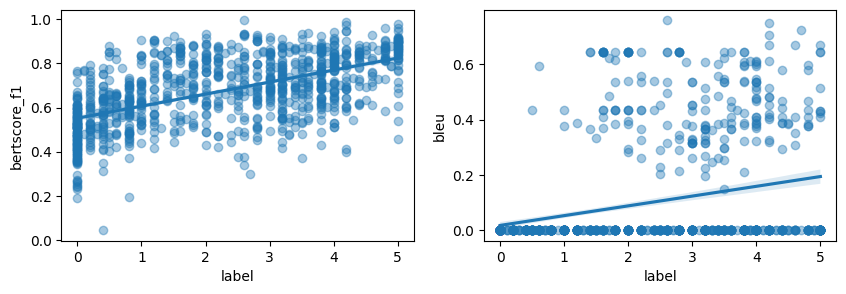

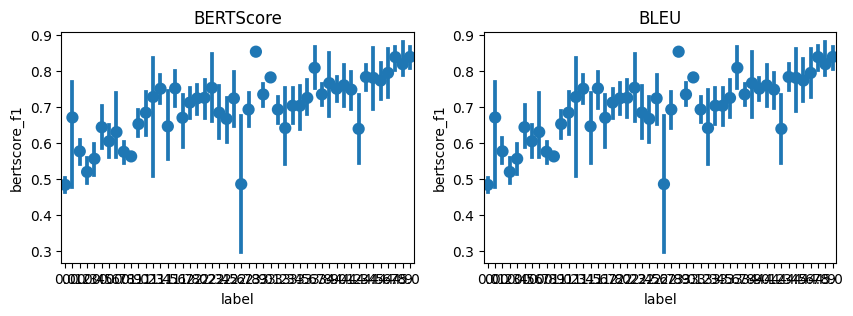

/tmp/ipykernel_6477/292845441.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(scores_df, x="bertscore_f1", hue="label", fill=True, ax=axes[0])
/tmp/ipykernel_6477/292845441.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(scores_df, x="bleu", hue="label", fill=True, ax=axes[1])


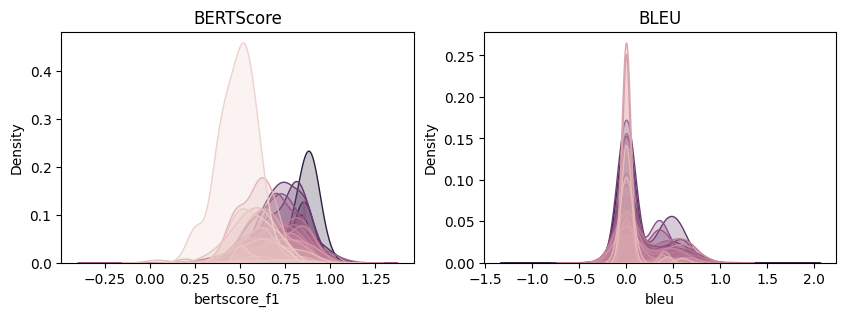

Mean


,bertscore_precision,bertscore_recall,bertscore_f1,bleu
label,,,,
0.0,0.491569,0.475820,0.484001,0.000000
0.1,0.645019,0.696478,0.670919,0.000000
0.2,0.572533,0.581020,0.576987,0.000000
0.3,0.528507,0.509972,0.519804,0.000000
0.4,0.549798,0.562439,0.556389,0.000000
0.5,0.634720,0.653226,0.643838,0.021736
0.6,0.610898,0.598756,0.604789,0.029771
0.7,0.632629,0.627013,0.630411,0.000000
0.8,0.561985,0.589443,0.575773,0.000000


Standard deviation


,bertscore_precision,bertscore_recall,bertscore_f1,bleu
label,,,,
0.0,0.119164,0.122970,0.108818,0.000000
0.1,0.210107,0.121010,0.165921,0.000000
0.2,0.118714,0.115639,0.105212,0.000000
0.3,0.028231,0.072674,0.039782,0.000000
0.4,0.140133,0.153565,0.138157,0.000000
0.5,0.161587,0.149704,0.142632,0.097207
0.6,0.114770,0.131999,0.107081,0.133139
0.7,0.104521,0.104074,0.103802,0.000000
0.8,0.127852,0.114589,0.106670,0.000000


In [ ]:
scores_df = pd.DataFrame(scores)
scores_df['label'] = scores_df['label'].round(1)
fix, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.regplot(x="label", y="bertscore_f1", data=scores_df, scatter_kws={'alpha': 0.4}, ax=axes[0])
sns.regplot(x="label", y="bleu", data=scores_df, scatter_kws={'alpha': 0.4}, ax=axes[1])
plt.show()

fix, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.pointplot(data=scores_df, x="label", y="bertscore_f1", join=False, ax=axes[0])
sns.pointplot(data=scores_df, x="label", y="bertscore_f1", join=False, ax=axes[1])
axes[0].set_title("BERTScore")
axes[1].set_title("BLEU")
axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
plt.show()

fix, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(scores_df, x="bertscore_f1", hue="label", fill=True, ax=axes[0])
sns.kdeplot(scores_df, x="bleu", hue="label", fill=True, ax=axes[1])
axes[0].set_title("BERTScore")
axes[1].set_title("BLEU")
axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
plt.show()
print('Mean')
display(scores_df.groupby('label').mean())
print('Standard deviation')
display(scores_df.groupby('label').std())

<Axes: xlabel='label', ylabel='bertscore_f1'>

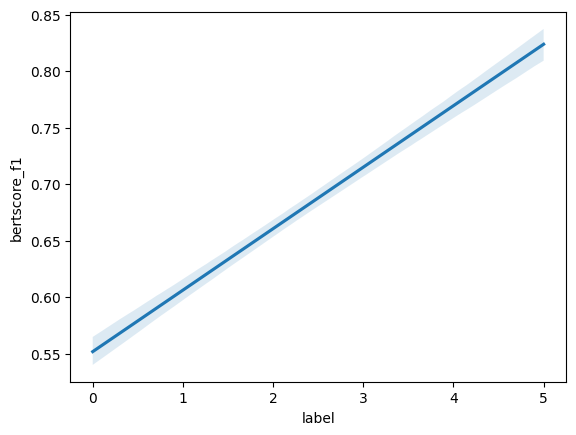

In [ ]:
sns.regplot(x="label", y="bertscore_f1", data=scores_df, ci=95, scatter=False, scatter_kws={'alpha': 0.4})

In [ ]:
## Using BERT-base on fine-tuned STS-B instead
import torch
import transformers



import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate

from bert_score import BERTScorer
from datasets import load_dataset
from datasets import concatenate_datasets
from transformers import logging
logging.set_verbosity_error()

scorer = BERTScorer(lang="en", rescale_with_baseline=True)
bleu = evaluate.load("bleu")

model_name = 'gchhablani/bert-base-cased-finetuned-stsb'
stsb_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
stsb_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
stsb_model.eval()

def fetch_scores(scorer, bleu, stsb_model, stsb_tokenizer, glue_dataset_name, feature1, feature2):
    data = load_dataset('glue', glue_dataset_name)
    merged_data = concatenate_datasets([data['train'], data['validation'], data['test']])

    scores = []
    count = 0
    for instance in merged_data:
        bert_score = scorer.score([instance[feature1]], [instance[feature2]], verbose=False)
        bleu_score = bleu.compute(predictions=[instance[feature1]], references=[instance[feature2]])['bleu']
        scores.append({'label': instance['label'], 'bertscore_precision': bert_score[0].item(), 'bertscore_recall': bert_score[1].item(), 'bertscore_f1': bert_score[2].item(), 'bleu': bleu_score})
        count += 1
        if count > 1000:
            break
    return scores

In [ ]:
data = load_dataset('glue', 'stsb')
merged_data = concatenate_datasets([data['train'], data['validation'], data['test']])



scores = []
count = 0
for instance in merged_data:
    count += 1
    stsb_tokenizer_output = stsb_tokenizer(instance['sentence1'], instance['sentence2'], padding=True, truncation=True, return_tensors="pt")
    stsb_model_output = stsb_model(**stsb_tokenizer_output)
    stsb_score = stsb_model_output['logits'].item()/5

    if count > 10:
        break

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 831.82it/s]


5.0 0.9755162239074707
3.799999952316284 0.94284029006958
3.799999952316284 0.938959789276123
2.5999999046325684 0.7791715621948242
4.25 0.9184970855712891
4.25 0.8400553703308106
0.5 0.07895504236221314
1.600000023841858 0.37012476921081544
2.200000047683716 0.5318073272705078
5.0 0.9872696876525879
4.199999809265137 0.8280219078063965


## Related papers:

BERTScore: https://arxiv.org/pdf/1904.09675.pdf

https://arxiv.org/pdf/2204.10206.pdf
